<a href="https://colab.research.google.com/github/BrunoLad/tcc-ufabc/blob/main/tcc_ufabc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!df -h
!cat /proc/cpuinfo
!cat /proc/meminfo

Filesystem      Size  Used Avail Use% Mounted on
overlay         108G   23G   86G  21% /
tmpfs            64M     0   64M   0% /dev
shm             5.8G     0  5.8G   0% /dev/shm
/dev/root       2.0G  1.1G  910M  54% /sbin/docker-init
tmpfs           6.4G   32K  6.4G   1% /var/colab
/dev/sda1        41G   24G   17G  59% /etc/hosts
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc 

## Monta o google drive para permitir a leitura dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalando o Stanza - Wrapper do Stanford CoreNLP para python e demais bibliotecas para manipulação e visualização

> É possível instalar o próprio NLTK que possui referência para o Stanford CoreNLP, porém o stanza é o [recomendado](https://stanfordnlp.github.io/CoreNLP/other-languages.html#official-stanza-package-by-the-stanford-nlp-group).

In [ ]:
!pip install stanza -U
!pip install matplotlib
!pip install pandas
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 4.9 MB/s 
     |████████████████████████████████| 240 kB 16.2 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=b4da7f0ecbe45aafe82edb727578922e18b0272eca3fb73e96b9fcbbdb6ee518
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Monta lista de classes de interesse para utilização durante o processamento

In [ ]:
from enum import Enum
import re

class BookInfo:
  def __init__(self, file_name):
    pattern = r'(.+)(?:___)(.+)\.txt'
    book_regex = re.compile(pattern)
    self.filename = file_name
    self.author = Author(book_regex.match(file_name).group(1))
    self.title = book_regex.match(file_name).group(2)
    self.bookid = None
    self.metadata = None

class Author:
  def __init__(self, name):
    self.name = name
    self.gender = None
  
  def add_gender(self, gender):
    self.gender = gender.value

class Gender(Enum):
  FEMALE = 'F'
  MALE = 'M'

class AnalysisResult:
  def __init__(self, book):
    self.book = book
    self.adjectives = dict.fromkeys([Gender.MALE, Gender.FEMALE])
    self.verbs = dict.fromkeys([Gender.MALE, Gender.FEMALE])
    self.occupations = dict.fromkeys([Gender.MALE, Gender.FEMALE])
    self.mentions = dict.fromkeys([Gender.MALE, Gender.FEMALE])
    self.characters = dict.fromkeys([Gender.MALE, Gender.FEMALE])

# Realiza o filtro dos livros que são de ficção
O filtro ocorre da seguinte forma:
Uma classe BookInfo é definida, que contém as propriedades do nome do arquivo (para obtenção do texto para análise posterior), uma ref pra class autor que contém nome e gênero do autor (para categorização posterior), título da obra (para identificação), id do livro (para obtenção dos metadados do livro e filtragem dos livros que são de ficção)

In [ ]:
import os
import regex
import json
from enum import Enum

# Necessário tratar os casos em que o nome do autor encontra-se na
# linha posterior ao título da obra
def extract_line_from_file(file_name, book):
  with open(file_name, 'r') as read_obj:
    for line in read_obj:
      if book.title in line and book.author in line:
        return line
  return ''

if __name__ == '__main__':
  BOOKS_HOME = '/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/txt'
  gutenberg_metadata_file = open('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/gutenberg-metadata.json')
  gutenberg_metadata = json.load(gutenberg_metadata_file)

  pattern = r'[^_]*$'
  digitPattern = r'\d+'
  re_bookId = re.compile(digitPattern)
  regex = re.compile(pattern, re.MULTILINE)
  fileList = os.listdir(BOOKS_HOME)
  newBooks = map(lambda book: BookInfo(book), fileList)
  newBooksList = list(newBooks)
  print(len(newBooksList))
  
  for book in newBooksList:
    line = extract_line_from_file('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/GUTINDEX.ALL14062022.txt', book)
    match = re_bookId.search(line)
    if match:
      book.bookid = match.group()
      
  filteredBooks = list(filter(lambda book: book.bookid is not None, newBooksList))
  fiction_books = filter(lambda book: book.bookid in gutenberg_metadata and re.search(r'[fF]iction', json.dumps(gutenberg_metadata[book.bookid]['subject'])), filteredBooks)
  fiction_books_list = list(fiction_books)
  print(len(fiction_books_list))

  for book in fiction_books_list:
    print('{0}: {1} by {2}'.format(book.bookid, book.title, book.author))

  

# Pega lista de livros já tratados

In [ ]:
import os
from heapq import nsmallest

if __name__ == '__main__':
  n = 150
  file_list = os.listdir('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned')
  # smallest = nsmallest(n, file_list, lambda x: os.stat('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned/' + x).st_size)
  # print(smallest)
  newBooks = map(lambda book: BookInfo(book), file_list)
  fiction_books_list = list(newBooks)
  print(len(fiction_books_list))



894


# Copia os livros de ficção para uma nova pasta para futuras manipulações
Move os livros para uma nova posta chamada **fiction** para que possa ser manipulado futuramente, deixando o corpus original intacto.

In [ ]:
from shutil import copyfile
import shutil
from pathlib import Path
import os

print(os.listdir())


FICTION_BOOKS_HOME = '/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/fiction'
CLEANED_BOOKS_HOME = '/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned'
cleaned_path = Path(CLEANED_BOOKS_HOME)

fileList = os.listdir(f'{FICTION_BOOKS_HOME}/')
newBooks = map(lambda book: BookInfo(book), fileList)
fiction_books_list = list(newBooks)
print(len(fiction_books_list))

# Remove a pasta e todo seu conteúdo caso ela já existia
# E Cria a pasta do zero
if cleaned_path.exists():
  shutil.rmtree(cleaned_path)
  # [f.unlink() for f in cleaned_path.itedir() if f.is_file()]
  # cleaned_path.rmdir()

cleaned_path.mkdir(parents = True, exist_ok = True)

for book in fiction_books_list:
  copyfile(FICTION_BOOKS_HOME + '/' + book.filename, CLEANED_BOOKS_HOME + '/' + book.filename)

['.config', 'corenlp_server-dd196007d92349a3.props', 'corenlp_server-8673c8456f004ac9.props', 'corenlp_server-ddbb8f0d58ac4f00.props', 'corenlp_server-236a6ec3c17848ad.props', 'corenlp_server-1a77e341ff884050.props', 'corenlp_server-3cf426901fc84e66.props', 'corenlp_server-6cee261bf06a479d.props', 'corenlp_server-6f5817a836c74892.props', 'corenlp_server-4820702e2aff40f5.props', 'corenlp', 'corenlp_server-e9e99c43fadf4fa7.props', 'corenlp_server-e6cc8b709d944037.props', 'drive', 'sample_data']
894


# Limpa os livros
Faz várias limpezas nos livros obtidos inplace (no mesmo arquivo que foi aberto e já inserido no diretório de livros de ficção), tanto a fim de aumentar a acurácia, quanto a fim de diminuir o tamanho dos livros com o intuito de otimizar o tempo de análise.

As limpezas efetuadas são:
- Transforma todos os whitespaces no mesmo tipo ' '
- Remove todos os dados antes do primeiro capitulos, nos livros que possuem o padrao:
  - Chapter [1I]
- Pega todo o conteúdo depois do separador 'by nomeAutor'
- Subsitui algarismos romanos por outra delimitador mais fácil de remover e depois remove linhas que iniciem com este delimitador que foi inserido
- Transforma o sinal tironiano num 'and' normal da língua inglesa
- Remove o nome do autor caso encontrado no livro
- Remove o título da obra caso encontrado no livro
- Remove espaços e quebras de linha em excesso

In [ ]:
import os
import re

CLEANED_BOOKS_HOME = '/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned'
# roman_pattern = """(M{1,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})(IX|IV|V?I{0,3})|M{0,4}(CM|C?D|D?C{1,3})(XC|XL|L?X{0,3})\
# (IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})(XC|X?L|L?X{1,3})(IX|IV|V?I{0,3})|M{0,4}(CM|CD|D?C{0,3})\
# (XC|XL|L?X{0,3})(IX|I?V|V?I{1,3}))"""
# Pattern adapted from https://www.oreilly.com/library/view/regular-expressions-cookbook/9780596802837/
chapter_pattern = "Chapter (\d+|(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3}))\..*$"
roman_pattern = "(?=[MDCLXVI])M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(I[XV]|V?I{0,3})\b\..*$"
loose_roman_pattern = "\b((?=[MDCLXV]|[I]{2,3})M*(C[MD]|D?C{0,3})(X[CL]|L?X{0,3})(V?I{0,3}))\b|\bIV\b|\bIX\b"

# Atualiza o livro (objeto do tipo arquivo, aberto na localização daquele livro)
# com o content passado
def update_book_data(book_file, content):
  book_file.seek(0)
  book_file.write(content)
  book_file.truncate()

# Elimina "impurezas" do corpo do livro
def clean_book(book):
  # with open(f'{FICTION_BOOKS_HOME}/{book.filename}', r) as bookfile:
  with open(f'{CLEANED_BOOKS_HOME}/{book.filename}', 'r+') as bookfile:
    book_content = bookfile.read()
    
    # Transforma todos os whitespaces no mesmo tipo
    # book_content = re.sub(r'\s', ' ', book_content)

    # Remove todos os dados antes do primeiro capitulo, nos livros que possuem o padrao
    # Chapter [1I]
    # book_content = re.sub(r"contents(\s*\w\.*'*)*\s{2}", '', book_content, flags = re.IGNORECASE | re.MULTILINE)
    content = re.split(r'chapter [i1]\.', book_content, flags = re.IGNORECASE | re.MULTILINE)
    book_content = content[1] if len(content) > 1 else content[0]

    # Pega todo o conteudo depois do separador 'by {authorName}'
    content = re.split(fr'by\s+{book.author.name}$', book_content, flags = re.IGNORECASE | re.MULTILINE)
    book_content = ''.join(content[1:]) if len(content) > 1 else content[0]
    
    # Remove Illustrations indicator
    book_content = re.sub(r'\[Illustration\w*\]', '', book_content, flags = re.IGNORECASE | re.MULTILINE)

    # # Remove indicativos de capítulos com algarismos romanos
    # book_content = re.sub(fr'{roman_pattern}', '', book_content, flags = re.IGNORECASE | re.MULTILINE)

    # Remove linhas com capítulo no formato Chapter I1.
    book_content = re.sub(fr'{chapter_pattern}', '', book_content, flags = re.IGNORECASE | re.MULTILINE)
    
    # # Subsitui algarismos romanos por outra delimitador mais fácil de remover
    # # Depois remova linhas que iniciem com este delimitador que foi inserido
    # book_content = re.sub(fr'{loose_roman_pattern}', '%%%%%', book_content, flags = re.IGNORECASE | re.MULTILINE)
    # book_content = re.sub(r'^(%{5}.*)$', '', book_content, flags = re.IGNORECASE | re.MULTILINE)


    # Transforma o sinal tironiano num 'and' normal da língua inglesa
    # para facilitar o processamento do texto
    book_content = re.sub(r'&', 'and', book_content)
    # Remove o nome do autor caso encontrado no livro
    book_content = re.sub(book.author.name, '', book_content, re.IGNORECASE)
    # Remove o título da obra caso encontrado no livro
    # book_content = re.sub(book.title, '', book_content, re.IGNORECASE)

    # Remove espaços e quebras de linha em excesso
    book_content = re.sub(r'\s+', ' ', book_content)

    update_book_data(bookfile, book_content)

fileList = os.listdir(f'{CLEANED_BOOKS_HOME}/')
newBooks = map(lambda book: BookInfo(book), fileList)
cleaned_books_list = list(newBooks)
print(len(cleaned_books_list))
  
for book in cleaned_books_list:
  clean_book(book)



894


# Lista de gênero dos autores [manualmente construído](https://docs.google.com/spreadsheets/d/17SkiDRPUTHVQLvM4FjEJjM_mdcdwqMiI4j3QYGxZfh4/edit#gid=544847314) e delimitação dos livros escolhidos para análise

In [ ]:
female_authors_for_analysis = { 'Agatha Christie', 'Beatrix Potter', 'Charlotte Bronte',
                               'Charlotte Mary Yonge', 'George Eliot', 'Jane Austen',
                               'Louisa May Alcott', 'Lucy Maud Montgomery',
                               'Mary Shelley', 'Virginia Woolf'}
"""
In total they collectively have 382 novels.
12 novels will be selected from Anthony Trollope and 8 from the rest
making it 84 in total, the same number as the total number of fiction books
written by female writers in the corpus.
Anthony Trollope, Bret Harte, Charles Dickens, Edward Stratemeyer,
Harold Bindloss, Henry James, Jack London, Nathaniel Hawthorne,
Wilkie Collins, William Dean Howells
"""
male_authors_chosen_for_analysis = { 'Anthony Trollope', 'Bret Harte', 'Charles Dickens',
                                    'Edward Stratemeyer', 'Harold Bindloss', 'Henry James',
                                    'Jack London', 'Nathaniel Hawthorne', 'Wilkie Collins',
                                    'William Dean Howells' }
authors_selected_for_analysis = female_authors_for_analysis | male_authors_chosen_for_analysis
male_fiction_books_list = list(filter(lambda book: book.author.name in male_authors_chosen_for_analysis, fiction_books_list))
chosen_fiction_books_list = fiction_books_list
# chosen_fiction_books_list = list(filter(lambda book: book.author.name in female_authors_for_analysis, fiction_books_list))
# for book in chosen_fiction_books_list:
#   book.author.add_gender(Gender.FEMALE)
# anthony_trollope_list = list(filter(lambda book: book.author.name == 'Anthony Trollope', male_fiction_books_list))[:12]
# for book in anthony_trollope_list:
#   book.author.add_gender(Gender.MALE)
# chosen_fiction_books_list += anthony_trollope_list
# for el in (male_authors_chosen_for_analysis - { 'Anthony Trollope' }):
#   sub_list = list(filter(lambda book: book.author.name == el, male_fiction_books_list))[:8]
#   for book in sub_list:
#     book.author.add_gender(Gender.MALE)
#   chosen_fiction_books_list += sub_list
chosen_fiction_books_list.sort(key=lambda x: (x.author.name, x.title))
for book in chosen_fiction_books_list:
  print(f'Author: {book.author.name} \t\t Gender: {book.author.gender} \t\t Book: {book.title}')
print(len(chosen_fiction_books_list))

Author: Agatha Christie 		 Gender: F 		 Book: The Mysterious Affair at Styles
Author: Agatha Christie 		 Gender: F 		 Book: The Secret Adversary
Author: Anthony Trollope 		 Gender: M 		 Book: An Old Man's Love
Author: Anthony Trollope 		 Gender: M 		 Book: An Unprotected Female at the Pyramids
Author: Anthony Trollope 		 Gender: M 		 Book: Ayala's Angel
Author: Anthony Trollope 		 Gender: M 		 Book: Barchester Towers
Author: Anthony Trollope 		 Gender: M 		 Book: Can You Forgive Her?
Author: Anthony Trollope 		 Gender: M 		 Book: Cousin Henry
Author: Anthony Trollope 		 Gender: M 		 Book: Doctor Thorne
Author: Anthony Trollope 		 Gender: M 		 Book: Dr. Wortle's School
Author: Anthony Trollope 		 Gender: M 		 Book: Framley Parsonage
Author: Anthony Trollope 		 Gender: M 		 Book: He Knew He Was Right
Author: Anthony Trollope 		 Gender: M 		 Book: Is He Popenjoy?
Author: Anthony Trollope 		 Gender: M 		 Book: Rachel Ray
Author: Beatrix Potter 		 Gender: F 		 Book: A Collection of Beatrix 

# Pipeline Completo

In [ ]:
import os
import stanza
import re
import nltk
import pickle
from nltk.corpus import brown
from nltk.corpus import wordnet as wn
from stanza.server import CoreNLPClient

nltk.download('wordnet')
nltk.download('wordnet31')
nltk.download('omw-1.4')
nltk.download('brown')

profession_expression = re.compile(r'Profession|position|occupation|line of work|employment|occupancy|work|role|labor|industry|job', re.IGNORECASE)

def get_hyponyms(synset, hyponyms = set()):
  for hyponym in synset.hyponyms():
    hyponyms |= set(synset.closure(lambda s: s.hyponyms()))
    hyponyms |= get_hyponyms(hyponym, hyponyms)
  return hyponyms | set(synset.closure(lambda s: s.hyponyms()))

def filter_occupations(set_data):
  return set(filter(lambda x: profession_expression.search(x.definition()), set_data))

work = wn.synsets('work')
job = wn.synsets('job')
occupation = wn.synset('occupation.n.01')
profession1 = wn.synset('profession.n.01')
profession2 = wn.synset('profession.n.02')

print(work)
print(job)

complete_list_professions = get_hyponyms(occupation).union(get_hyponyms(profession1), get_hyponyms(profession2))

for x in work:
  complete_list_professions = complete_list_professions.union(get_hyponyms(x))

for x in job:
  complete_list_professions = complete_list_professions.union(get_hyponyms(x))

print(complete_list_professions)

complete_list_professions = filter_occupations(complete_list_professions)

complete_list_professions = list(map(lambda x: x.lemma_names(), complete_list_professions))

complete_list_professions = [item for sublist in complete_list_professions for item in sublist]
complete_list_professions = list(map(lambda x: x.replace('_', ' '), complete_list_professions))

print(complete_list_professions)
print(len(complete_list_professions))

# Download the Stanford CoreNLP package with Stanza's installation command
# This'll take several minutes, depending on the network speed
corenlp_dir = './corenlp'
stanza.install_corenlp(dir=corenlp_dir)

# Set the CORENLP_HOME environment variable to point to the installation location
os.environ['CORENLP_HOME'] = corenlp_dir
# Skipped #4 => Anthony Trollope's Ayala's Angel 
# Skipped #5 => Anthony Trollope's Barchester Towers
# Skipped #6 => Anthony Trollope's Can You Forgive Her?
# Skipped #7 => Anthony Trollope's Castle Richmond
# Skipped #9 => Anthony Trollope's Doctor Thorne
# Skipped #11 => Anthony Trollope's Framley Parsonage
# Skipped #12 => He Knew He Was Right by Anthony Trollope
# Skipped #13 => Is He Popenjoy? by Anthony Trollope
# Problem running #14 (cleaned improperly) => A Collection of Beatrix Potter Stories by Beatrix Potter
# Skipped #33 => A First Family of Tasajara by Bret Harte
# Skipped #36 => Cressy by Bret Harte
# Skipped #39 => From Sand Hill to Pine by Bret Harte
# Skipped #42 => A Tale of Two Cities by Charles Dickens
# Skipped #44 => David Copperfield by Charles Dickens
# Skipped #47 => Great Expectations by Charles Dickens
# Skipped #48 => Hard Times by Charles Dickens
# Skipped #49 => Jane Eyre by Charlotte Bronte
# Skipped #50 => Villette by Charlotte Bronte
# Skipped #51 => Modern Broods by Charlotte Mary Yonge
# Problem with #52
# Skipped #53 => The Two Guardians by Charlotte Mary Yonge

for book in chosen_fiction_books_list[4:5]:
  with open('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned/' + book.filename, 'r') as file:
    data = file.read()
    print('{0} by {1}'.format(book.title, book.author.name))
    ann = None
    with CoreNLPClient(
        annotators = ['tokenize', 'ssplit', 'pos', 'lemma', 'ner', 'depparse', 'natlog', 'openie', 'coref'],
        be_quiet = False,
        timeout = 150000000000,
        memory = '10G',
        endpoint='http://localhost:9001',
        max_char_length = 20000000000000000) as client:
          ann = client.annotate(data)

          sentences = ann.sentence
          maleRegex = re.compile(r'\b(he|his|him|himself)\b', re.IGNORECASE)
          femaleRegex = re.compile(r'\b(her|she|hers|herself)\b', re.IGNORECASE)
          maleMentions = 0
          femaleMentions = 0
          male_characters = set()
          female_characters = set()

          """MENCOES"""

          for sentence in sentences:
            for triple in sentence.openieTriple:
              if len(triple.tree.node) > 0 and (any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens)):
                # print(f'Subject tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.subjectTokens))} related to Object tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.objectTokens))}')
                for su in triple.subjectTokens:
                  if maleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
                    maleMentions += 1
                    break
                  elif femaleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
                    femaleMentions += 1
                    break

          chains = ann.corefChain
          chain_dict = dict()

          for index, chain in enumerate(chains):
            chain_dict[index]={}
            chain_dict[index]['ref']=''
            chain_dict[index]['mentions']=[{'mentionID':mention.mentionID,
                                                    'mentionType':mention.mentionType,
                                                    'number':mention.number,
                                                    'gender':mention.gender,
                                                    'animacy':mention.animacy,
                                                    'beginIndex':mention.beginIndex,
                                                    'endIndex':mention.endIndex,
                                                    'headIndex':mention.headIndex,
                                                    'sentenceIndex':mention.sentenceIndex,
                                                    'position':mention.position,
                                                    'ref':'',
                                                    } for mention in chain.mention ]
          for k, v in chain_dict.items():
            mentions = v['mentions']
            for mention in mentions:
              words_list = ann.sentence[mention['sentenceIndex']].token[mention['beginIndex']:mention['endIndex']]
              mention['ref'] = ' '.join(t.word for t in words_list)
              if mention['mentionType'] == 'PROPER' and any(word.pos == 'NNP' for word in words_list):
                if mention['gender'] == 'MALE':
                  maleMentions += 1
                  for word in words_list:
                    if word.pos == 'NNP':
                      male_characters.add(word.value)
                elif mention['gender'] == 'FEMALE':
                  femaleMentions += 1
                  for word in words_list:
                    if word.pos == 'NNP':
                      female_characters.add(word.value)
          print(f'The number of males mentioned in the text is {maleMentions}')
          print(f'The number of females mentioned in the text is {femaleMentions}')
          print(f'Male character set {male_characters}')
          print(f'Female character set {female_characters}')

          """ADJECTIVES"""

          male_adjective_list = []
          female_adjective_list = []
          male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
          female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
          # Get adjectives for pronoun or possessive pronoun
          for sentence in sentences:
            for triple in sentence.openieTriple:
              # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
              if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
                male_verification_list = list(filter(male_verification, triple.subjectTokens))
                female_verification_list = list(filter(female_verification, triple.subjectTokens))
                if len(male_verification_list) > 0:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                      male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
                elif len(female_verification_list) > 0:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                      female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
          # Get adjectives for proper noun
          for sentence in sentences:
            for triple in sentence.openieTriple:
              if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
                # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
                tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
                subject = ' '.join(tokens)
                if subject in male_characters:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                      male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
                elif subject in female_characters:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
                      female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
          
          """VERBS"""
          male_verb_list = []
          female_verb_list = []
          male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
          female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
          # Get adjectives for pronoun or possessive pronoun
          for sentence in sentences:
            for triple in sentence.openieTriple:
              # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
              if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
                male_verification_list = list(filter(male_verification, triple.subjectTokens))
                female_verification_list = list(filter(female_verification, triple.subjectTokens))
                if len(male_verification_list) > 0:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                      male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
                elif len(female_verification_list) > 0:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                      female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
          # Get adjectives for proper noun
          for sentence in sentences:
            for triple in sentence.openieTriple:
              if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
                # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
                tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
                subject = ' '.join(tokens)
                if subject in male_characters:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                      male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
                elif subject in female_characters:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
                      female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
          
          """OCCUPATIONS"""
          male_occupation_list = []
          female_occupation_list = []
          male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
          female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
          # Get occupation for pronoun or possessive pronoun
          for sentence in sentences:
            for triple in sentence.openieTriple:
              # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
              if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
                male_verification_list = list(filter(male_verification, triple.subjectTokens))
                female_verification_list = list(filter(female_verification, triple.subjectTokens))
                if len(male_verification_list) > 0:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                      male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
                elif len(female_verification_list) > 0:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                      female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
          # Get professions for proper noun
          for sentence in sentences:
            for triple in sentence.openieTriple:
              if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
                # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
                tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
                subject = ' '.join(tokens)
                if subject in male_characters:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                      male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue
                elif subject in female_characters:
                  for obj in triple.objectTokens:
                    if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
                      female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
                  continue

          print(male_occupation_list)
          print(female_occupation_list)

          """ARMAZENA OS DADOS"""
          RESULTS_HOME = '/content/drive/MyDrive/TCC/results'

          data = AnalysisResult(book)
          data.adjectives[Gender.MALE] = male_adjective_list
          data.adjectives[Gender.FEMALE] = female_adjective_list
          data.verbs[Gender.MALE] = male_verb_list
          data.verbs[Gender.FEMALE] = female_verb_list
          data.occupations[Gender.MALE] = male_occupation_list
          data.occupations[Gender.FEMALE] = female_occupation_list
          data.mentions[Gender.MALE] = maleMentions
          data.mentions[Gender.FEMALE] = femaleMentions
          data.characters[Gender.MALE] = male_characters
          data.characters[Gender.FEMALE] = female_characters

          print(data.adjectives[Gender.MALE])
          print(data.adjectives[Gender.FEMALE])
          print(re.sub('txt', 'pickle', data.book.filename))

          with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', data.book.filename)}", 'wb') as f:
            pickle.dump(data, f)

          objdump = None
          
          with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', data.book.filename)}", 'rb') as f:
              # Stores the now deserialized information into objdump
              objdump = pickle.load(f)

          print(objdump.adjectives[Gender.MALE])
          print(objdump.adjectives[Gender.FEMALE])
          print(objdump.verbs[Gender.MALE])
          print(objdump.verbs[Gender.FEMALE])
          print(objdump.occupations[Gender.MALE])
          print(objdump.occupations[Gender.FEMALE])
          print(objdump.mentions[Gender.MALE])
          print(objdump.mentions[Gender.FEMALE])
          print(objdump.characters[Gender.MALE])
          print(objdump.characters[Gender.FEMALE])
          print(objdump.book.filename)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet31 to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


[Synset('work.n.01'), Synset('work.n.02'), Synset('employment.n.02'), Synset('study.n.02'), Synset('work.n.05'), Synset('workplace.n.01'), Synset('oeuvre.n.01'), Synset('work.v.01'), Synset('work.v.02'), Synset('work.v.03'), Synset('function.v.01'), Synset('work.v.05'), Synset('exercise.v.03'), Synset('make.v.36'), Synset('work.v.08'), Synset('work.v.09'), Synset('work.v.10'), Synset('bring.v.03'), Synset('work.v.12'), Synset('cultivate.v.02'), Synset('work.v.14'), Synset('influence.v.01'), Synset('work.v.16'), Synset('work.v.17'), Synset('work.v.18'), Synset('work.v.19'), Synset('shape.v.02'), Synset('work.v.21'), Synset('knead.v.01'), Synset('exploit.v.01'), Synset('solve.v.01'), Synset('ferment.v.03'), Synset('sour.v.01'), Synset('work.v.27')]
[Synset('occupation.n.01'), Synset('job.n.02'), Synset('job.n.03'), Synset('job.n.04'), Synset('job.n.05'), Synset('job.n.06'), Synset('job.n.07'), Synset('problem.n.01'), Synset('job.n.09'), Synset('job.n.10'), Synset('job.n.11'), Synset('job

INFO:stanza:Installing CoreNLP package into ./corenlp


{Synset('nurturance.n.01'), Synset('sheepwalk.n.01'), Synset('slave.v.01'), Synset('tender_loving_care.n.01'), Synset('anointing.n.01'), Synset('logging.n.01'), Synset('testing.n.01'), Synset('openwork.n.01'), Synset('naprapathy.n.01'), Synset('modality.n.04'), Synset('magistracy.n.01'), Synset('costing.n.01'), Synset('product_research.n.01'), Synset('metalwork.n.01'), Synset('bishopry.n.01'), Synset('computerization.n.01'), Synset('antipyresis.n.01'), Synset('medical_care.n.01'), Synset('blackmail.v.01'), Synset('supererogation.n.01'), Synset('secretary_of_the_navy.n.01'), Synset('watch.n.03'), Synset('cabinetwork.n.01'), Synset('ministry.n.04'), Synset('thrombolytic_therapy.n.01'), Synset('plug_away.v.01'), Synset('dairy.n.01'), Synset('lace_making.n.01'), Synset('intramuscular_injection.n.01'), Synset('militate.v.01'), Synset('artist's_loft.n.01'), Synset('effort.n.02'), Synset('introduction.n.04'), Synset('implosion_therapy.n.01'), Synset('prefecture.n.02'), Synset('surveillance.n.

INFO:stanza:Writing properties to tmp file: corenlp_server-cc81f25c809c4e59.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 150000000000 -threads 5 -maxCharLength 20000000000000000 -quiet False -serverProperties corenlp_server-cc81f25c809c4e59.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Ayala's Angel by Anthony Trollope


AnnotationException: ignored

# Faz [anotações](https://stanfordnlp.github.io/CoreNLP/annotators.html) suportadas pelo StanfordCoreNLP na base de livros:

A lista de protocolo de mensagens de retorno pode ser encontradas aqui https://github.com/stanfordnlp/stanza/blob/main/doc/CoreNLP.proto

In [ ]:
import os
import stanza
from stanza.server import CoreNLPClient

# Download the Stanford CoreNLP package with Stanza's installation command
# This'll take several minutes, depending on the network speed
corenlp_dir = './corenlp'
stanza.install_corenlp(dir=corenlp_dir)

# Set the CORENLP_HOME environment variable to point to the installation location
os.environ['CORENLP_HOME'] = corenlp_dir

with open('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/cleaned/' + chosen_fiction_books_list[3].filename, 'r') as file:
  data = file.read()

print('{0} by {1}'.format(chosen_fiction_books_list[3].title, chosen_fiction_books_list[3].author.name))

ann = None

with CoreNLPClient(
    annotators = ['tokenize', 'ssplit', 'pos', 'lemma', 'ner', 'depparse', 'natlog', 'openie', 'coref'],
    be_quiet = False,
    timeout = 15000000000,
    memory = '10G',
    endpoint='http://localhost:9001',
    max_char_length = 2000000000000) as client:
  ann = client.annotate(data)

INFO:stanza:Installing CoreNLP package into ./corenlp


INFO:stanza:Writing properties to tmp file: corenlp_server-5ddac701daaa415f.props
INFO:stanza:Starting server with command: java -Xmx10G -cp ./corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9001 -timeout 15000000000 -threads 5 -maxCharLength 2000000000000 -quiet False -serverProperties corenlp_server-5ddac701daaa415f.props -annotators tokenize,ssplit,pos,lemma,ner,depparse,natlog,openie,coref -preload -outputFormat serialized


Can You Forgive Her_ by Anthony Trollope


# Quantidade de menções por gênero

Tanto de nome próprio, quanto de pronome

In [ ]:
sentences = ann.sentence
maleRegex = re.compile(r'\b(he|his|him|himself)\b', re.IGNORECASE)
femaleRegex = re.compile(r'\b(her|she|hers|herself)\b', re.IGNORECASE)
maleMentions = 0
femaleMentions = 0
male_characters = set()
female_characters = set()

for sentence in sentences:
  for triple in sentence.openieTriple:
    if len(triple.tree.node) > 0 and (any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens)):
      # print(f'Subject tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.subjectTokens))} related to Object tokens: {list(map(lambda x: sentences[x.sentenceIndex].token[x.tokenIndex].value, triple.objectTokens))}')
      for su in triple.subjectTokens:
        if maleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
          maleMentions += 1
          break
        elif femaleRegex.search(sentences[su.sentenceIndex].token[su.tokenIndex].value):
          femaleMentions += 1
          break

chains = ann.corefChain
chain_dict = dict()

for index, chain in enumerate(chains):
  chain_dict[index]={}
  chain_dict[index]['ref']=''
  chain_dict[index]['mentions']=[{'mentionID':mention.mentionID,
                                          'mentionType':mention.mentionType,
                                          'number':mention.number,
                                          'gender':mention.gender,
                                          'animacy':mention.animacy,
                                          'beginIndex':mention.beginIndex,
                                          'endIndex':mention.endIndex,
                                          'headIndex':mention.headIndex,
                                          'sentenceIndex':mention.sentenceIndex,
                                          'position':mention.position,
                                          'ref':'',
                                          } for mention in chain.mention ]
for k, v in chain_dict.items():
  mentions = v['mentions']
  for mention in mentions:
    words_list = ann.sentence[mention['sentenceIndex']].token[mention['beginIndex']:mention['endIndex']]
    mention['ref'] = ' '.join(t.word for t in words_list)
    if mention['mentionType'] == 'PROPER' and any(word.pos == 'NNP' for word in words_list):
      if mention['gender'] == 'MALE':
        maleMentions += 1
        for word in words_list:
          if word.pos == 'NNP':
            male_characters.add(word.value)
      elif mention['gender'] == 'FEMALE':
        femaleMentions += 1
        for word in words_list:
          if word.pos == 'NNP':
            female_characters.add(word.value)
print(f'The number of males mentioned in the text is {maleMentions}')
print(f'The number of females mentioned in the text is {femaleMentions}')
print(f'Male character set {male_characters}')
print(f'Female character set {female_characters}')

NameError: ignored

In [ ]:
mCount = 0
fCount = 0
for sentence in sentences:
  for mention in sentence.mentions:
    if mention.ner == 'PERSON':
      if mention.gender == 'MALE':
        mCount += 1
      elif mention.gender == 'FEMALE':
        fCount +=1
print(f'Male Count {mCount}')
print(f'Female Count {fCount}')

Male Count 770
Female Count 508


In [ ]:
      # TODO: find an article that gives an appropriate confidence rating
      # read https://nlp.stanford.edu/pubs/2015angeli-openie.pdf
      # print(triple.subjectTokens)

# actualIndex = 0
# indexSize = [None] * len(sentences)
# for i, sentence in enumerate(sentences):
#   if i != 0:
#     indexSize[i] = len(sentence.token) + indexSize[i - 1]
#   else:
#     indexSize[i] = len(sentence.token)
# # Unfortunately doesn't work, since only personal pronouns get attributed the gender field.
# for sentence in sentences:
#   for mention in sentence.mentions:
#     if mention.ner == 'PERSON':
#       startIndex = mention.tokenStartInSentenceInclusive - (indexSize[mention.sentenceIndex - 1] or 0)
#       endIndex = mention.tokenEndInSentenceExclusive - (indexSize[mention.sentenceIndex - 1] or 0)

#       if sentences[mention.sentenceIndex].token[startIndex:endIndex].pos == 'NNP':
#         if mention.gender == 'MALE':
#           maleMentions += 1
#         elif mention.gender == 'FEMALE':
#           femaleMentions += 1

# TODO: Consider using coref to get genders of tokens identified with NER as person
# or use genderAPI to determine this, maybe try both methods and compile results as reference.
# NER annotator, itself, already attributes gender to PERSON

# Como personagens de cada gênero são descritos fisicamente

['quick', 'nervous', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'suspicious', 'suspicious', 'nervous', 'suspicious', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'agitated', 'agitated', 'red', 'red', 'ugly', 'ugly', 'young', 'early', 'Victorian', 'delightful', 'Victorian', 'delightful', 'early', 'delightful', 'early', 'Victorian', 'delightful', 'early', 'Victorian', 'deeper', 'last', 'heavy', 'heavy', 'big', 'small', 'Private', 'Private', 'like', 'like', 'fullest', 'more', 'other', 'good', 'other', 'good', 'attractive', 'attractive', 'tired', 'tired', 'little', 'little', 'unusual', 'unusual', 'other', 'other', 'Secret', 'monotone', 'Secret', 'low', 'monotone', 'precious', 'possible', 'unassuming', 'unassuming', 'un

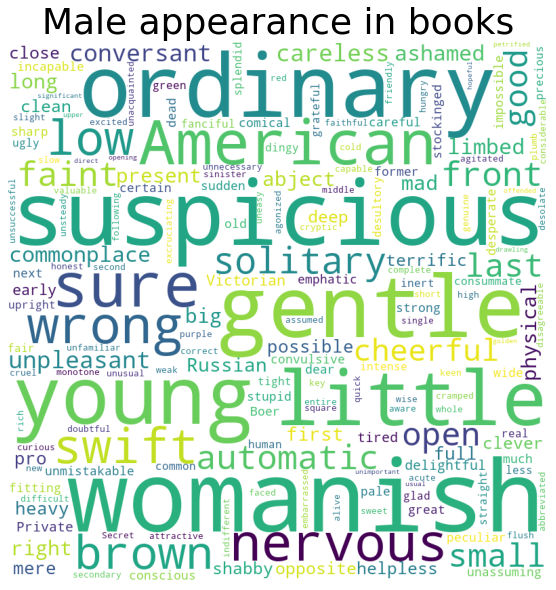

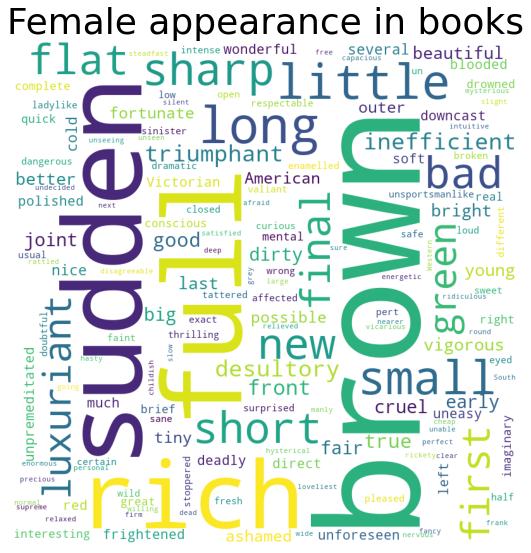

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt

male_adjective_list = []
female_adjective_list = []
male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
# Get adjectives for pronoun or possessive pronoun
for sentence in sentences:
  for triple in sentence.openieTriple:
    # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
      male_verification_list = list(filter(male_verification, triple.subjectTokens))
      female_verification_list = list(filter(female_verification, triple.subjectTokens))
      if len(male_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
            male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif len(female_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
            female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
# Get adjectives for proper noun
for sentence in sentences:
  for triple in sentence.openieTriple:
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
      # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
      tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
      subject = ' '.join(tokens)
      if subject in male_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
            male_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif subject in female_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('JJ'):
            female_adjective_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue

wordcloud = WordCloud(width = 800, height = 800,
                background_color = 'white',
                collocations = False,
                min_font_size = 10).generate(' '.join(male_adjective_list))

print(male_adjective_list)
print(female_adjective_list)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Male appearance in books', fontsize = 36)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud = WordCloud(width = 800, height = 800,
                      background_color = 'white',
                      collocations = False,
                      min_font_size = 10).generate(' '.join(female_adjective_list))

plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Female appearance in books', fontsize = 36)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

# Como personagens de cada gênero são representados

['quick', 'nervous', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'suspicious', 'suspicious', 'nervous', 'suspicious', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'agitated', 'agitated', 'red', 'red', 'ugly', 'ugly', 'young', 'early', 'Victorian', 'delightful', 'Victorian', 'delightful', 'early', 'delightful', 'early', 'Victorian', 'delightful', 'early', 'Victorian', 'deeper', 'last', 'heavy', 'heavy', 'big', 'small', 'Private', 'Private', 'like', 'like', 'fullest', 'more', 'other', 'good', 'other', 'good', 'attractive', 'attractive', 'tired', 'tired', 'little', 'little', 'unusual', 'unusual', 'other', 'other', 'Secret', 'monotone', 'Secret', 'low', 'monotone', 'precious', 'possible', 'unassuming', 'unassuming', 'un

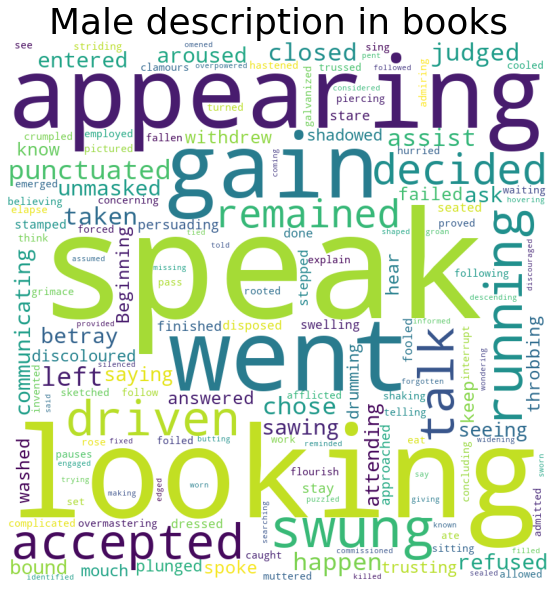

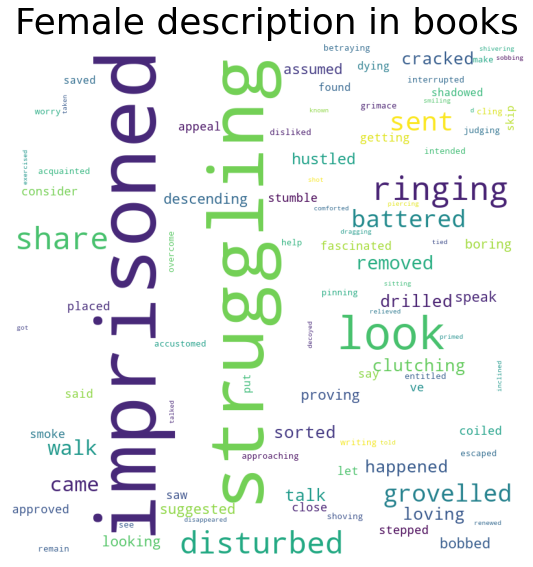

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt

male_verb_list = []
female_verb_list = []
male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
# Get adjectives for pronoun or possessive pronoun
for sentence in sentences:
  for triple in sentence.openieTriple:
    # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
      male_verification_list = list(filter(male_verification, triple.subjectTokens))
      female_verification_list = list(filter(female_verification, triple.subjectTokens))
      if len(male_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
            male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif len(female_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
            female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
# Get adjectives for proper noun
for sentence in sentences:
  for triple in sentence.openieTriple:
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
      # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
      tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
      subject = ' '.join(tokens)
      if subject in male_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
            male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif subject in female_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].pos.startswith('VB'):
            female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue

wordcloud = WordCloud(width = 800, height = 800,
                background_color = 'white',
                collocations = False,
                min_font_size = 10).generate(' '.join(male_verb_list))

print(male_adjective_list)
print(female_adjective_list)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Male description in books', fontsize = 36)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud = WordCloud(width = 800, height = 800,
                      background_color = 'white',
                      collocations = False,
                      min_font_size = 10).generate(' '.join(female_verb_list))

plt.figure(figsize = (8, 8), facecolor = None)
plt.title('Female description in books', fontsize = 36)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
 
plt.show()

# Exploração de montagem de lista de profissões utilizando o wordnet
Utilizando lista de hipônimos para algumas palavras chaves para essa construção.

In [ ]:
import re
import nltk
nltk.download('wordnet')
nltk.download('wordnet31')
nltk.download('omw-1.4')
nltk.download('brown')
from nltk.corpus import brown
from nltk.corpus import wordnet as wn

profession_expression = re.compile(r'Profession|position|occupation|line of work|employment|occupancy|work|role|labor|industry|job', re.IGNORECASE)

def get_hyponyms(synset, hyponyms = set()):
  for hyponym in synset.hyponyms():
    hyponyms |= set(synset.closure(lambda s: s.hyponyms()))
    hyponyms |= get_hyponyms(hyponym, hyponyms)
  return hyponyms | set(synset.closure(lambda s: s.hyponyms()))

def filter_occupations(set_data):
  return set(filter(lambda x: profession_expression.search(x.definition()), set_data))

work = wn.synsets('work')
job = wn.synsets('job')
occupation = wn.synset('occupation.n.01')
profession1 = wn.synset('profession.n.01')
profession2 = wn.synset('profession.n.02')

print(work)
print(job)

complete_list_professions = get_hyponyms(occupation).union(get_hyponyms(profession1), get_hyponyms(profession2))

for x in work:
  complete_list_professions = complete_list_professions.union(get_hyponyms(x))

for x in job:
  complete_list_professions = complete_list_professions.union(get_hyponyms(x))

print(complete_list_professions)

complete_list_professions = filter_occupations(complete_list_professions)

complete_list_professions = list(map(lambda x: x.lemma_names(), complete_list_professions))

complete_list_professions = [item for sublist in complete_list_professions for item in sublist]
complete_list_professions = list(map(lambda x: x.replace('_', ' '), complete_list_professions))

print(complete_list_professions)
print(len(complete_list_professions))

# data = []

# for o in list(filter_occupations(complete_list_professions)):
#   data += o.lemma_names()

# print(data)
# print(len(data))

# for p in list(get_hyponyms(occupation)):
#   p.
# print(get_hyponyms(profession1).union(get_hyponyms(profession2)))

# occupations = list(set([w for s in occupation.closure(lambda s:s.hyponyms()) for w in s.lemma_names()]))
# professions = list(set([w for s in profession1.closure(lambda s:s.hyponyms()) for w in s.lemma_names()])
#                     .union(set([w for s in profession2.closure(lambda s:s.hyponyms()) for w in s.lemma_names()])))

# print(occupations)
# print(professions)

# for syn in wn.synsets('occupation'):
#   print(syn.hyponyms())
# print(wn.synsets('profession'))
# for syn in wn.synsets('profession'):
#   print(syn.hyponyms())

#print(wn.synsets('prostitute'))

from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt

male_occupation_list = []
female_occupation_list = []
male_verification = lambda x: maleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
female_verification = lambda x: femaleRegex.search(sentences[x.sentenceIndex].token[x.tokenIndex].value)
# Get occupation for pronoun or possessive pronoun
for sentence in sentences:
  for triple in sentence.openieTriple:
    # (sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') and (sentences[subject.sentenceIndex].token[subject.tokenIndex].value in male_characters or sentences[subject.sentenceIndex].token[subject.tokenIndex].value in female_characters
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('PRP') for subject in triple.subjectTokens):
      male_verification_list = list(filter(male_verification, triple.subjectTokens))
      female_verification_list = list(filter(female_verification, triple.subjectTokens))
      if len(male_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
            male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif len(female_verification_list) > 0:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
            female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
# Get professions for proper noun
for sentence in sentences:
  for triple in sentence.openieTriple:
    if any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos.startswith('NNP') for subject in triple.subjectTokens):
      # print(triple.subjectTokens[0].sentenceIndex, triple.subjectTokens[-1].sentenceIndex)
      tokens = [sentences[x.sentenceIndex].token[x.tokenIndex].value for x in triple.subjectTokens]
      subject = ' '.join(tokens)
      if subject in male_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
            male_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue
      elif subject in female_characters:
        for obj in triple.objectTokens:
          if sentences[obj.sentenceIndex].token[obj.tokenIndex].value in complete_list_professions:
            female_verb_list.append(sentences[obj.sentenceIndex].token[obj.tokenIndex].value)
        continue

print(male_occupation_list)
print(female_occupation_list)

if len(male_occupation_list) > 0:
  wordcloud = WordCloud(width = 800, height = 800,
                        background_color = 'white',
                        collocations = False,
                        min_font_size = 10).generate(' '.join(male_occupation_list))
  # plot the WordCloud image                      
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.title('Male occupation in books', fontsize = 36)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  
  plt.show()


if len(female_occupation_list) > 0:
  wordcloud = WordCloud(width = 800, height = 800,
                        background_color = 'white',
                        collocations = False,
                        min_font_size = 10).generate(' '.join(female_occupation_list))

  plt.figure(figsize = (8, 8), facecolor = None)
  plt.title('Female occupation in books', fontsize = 36)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.tight_layout(pad = 0)
  
  plt.show()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet31 to /root/nltk_data...
[nltk_data]   Package wordnet31 is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


[Synset('work.n.01'), Synset('work.n.02'), Synset('employment.n.02'), Synset('study.n.02'), Synset('work.n.05'), Synset('workplace.n.01'), Synset('oeuvre.n.01'), Synset('work.v.01'), Synset('work.v.02'), Synset('work.v.03'), Synset('function.v.01'), Synset('work.v.05'), Synset('exercise.v.03'), Synset('make.v.36'), Synset('work.v.08'), Synset('work.v.09'), Synset('work.v.10'), Synset('bring.v.03'), Synset('work.v.12'), Synset('cultivate.v.02'), Synset('work.v.14'), Synset('influence.v.01'), Synset('work.v.16'), Synset('work.v.17'), Synset('work.v.18'), Synset('work.v.19'), Synset('shape.v.02'), Synset('work.v.21'), Synset('knead.v.01'), Synset('exploit.v.01'), Synset('solve.v.01'), Synset('ferment.v.03'), Synset('sour.v.01'), Synset('work.v.27')]
[Synset('occupation.n.01'), Synset('job.n.02'), Synset('job.n.03'), Synset('job.n.04'), Synset('job.n.05'), Synset('job.n.06'), Synset('job.n.07'), Synset('problem.n.01'), Synset('job.n.09'), Synset('job.n.10'), Synset('job.n.11'), Synset('job

# Pickle dados para manipulação futura

In [ ]:
!cp drive/MyDrive/TCC/classes.py .

In [ ]:
import pickle
# import classes

RESULTS_HOME = '/content/drive/MyDrive/TCC/results'

data = AnalysisResult(chosen_fiction_books_list[3])
data.adjectives[Gender.MALE] = male_adjective_list
data.adjectives[Gender.FEMALE] = female_adjective_list
data.verbs[Gender.MALE] = male_verb_list
data.verbs[Gender.FEMALE] = female_verb_list
data.occupations[Gender.MALE] = male_occupation_list
data.occupations[Gender.FEMALE] = female_occupation_list
data.mentions[Gender.MALE] = maleMentions
data.mentions[Gender.FEMALE] = femaleMentions

print(data.adjectives[Gender.MALE])
print(data.adjectives[Gender.FEMALE])
print(re.sub('txt', 'pickle', data.book.filename))

with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', data.book.filename)}", 'wb') as f:
  pickle.dump(data, f)

objdump = None
 
with open(f"{RESULTS_HOME}/{re.sub('txt', 'pickle', data.book.filename)}", 'rb') as f:
    # Stores the now deserialized information into objdump
    objdump = pickle.load(f)

print(objdump.adjectives[Gender.MALE])
print(objdump.adjectives[Gender.FEMALE])
print(objdump.verbs[Gender.MALE])
print(objdump.verbs[Gender.FEMALE])
print(objdump.occupations[Gender.MALE])
print(objdump.occupations[Gender.FEMALE])
print(objdump.mentions[Gender.MALE])
print(objdump.mentions[Gender.FEMALE])
print(objdump.book.filename)



['quick', 'nervous', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'suspicious', 'suspicious', 'nervous', 'suspicious', 'nervous', 'suspicious', 'nervous', 'swift', 'suspicious', 'suspicious', 'nervous', 'swift', 'suspicious', 'nervous', 'suspicious', 'swift', 'suspicious', 'agitated', 'agitated', 'red', 'red', 'ugly', 'ugly', 'young', 'early', 'Victorian', 'delightful', 'Victorian', 'delightful', 'early', 'delightful', 'early', 'Victorian', 'delightful', 'early', 'Victorian', 'deeper', 'last', 'heavy', 'heavy', 'big', 'small', 'Private', 'Private', 'like', 'like', 'fullest', 'more', 'other', 'good', 'other', 'good', 'attractive', 'attractive', 'tired', 'tired', 'little', 'little', 'unusual', 'unusual', 'other', 'other', 'Secret', 'monotone', 'Secret', 'low', 'monotone', 'precious', 'possible', 'unassuming', 'unassuming', 'un

# Verificar se o client CoreNLP java, invocado pelo Stanza, está em execução

In [ ]:
!ps -o pid,cmd | grep java
!ls $CORENLP_HOME

In [ ]:
# Iterate over all detected entity mentions
print("{:30s}\t{}".format("Mention", "Type"))

for sent in ann.sentence:
    for m in sent.mentions:
        print("{:30s}\t{}".format(m.entityMentionText, m.entityType))

A saída de streaming foi truncada nas últimas 5000 linhas.
Priscilla                     	PERSON
prophet                       	TITLE
his                           	PERSON
Barbecue-Smith                	PERSON
ten                           	NUMBER
eight                         	NUMBER
He                            	PERSON
he                            	PERSON
he                            	PERSON
his                           	PERSON
He                            	PERSON
One                           	NUMBER
Denis                         	PERSON
he                            	PERSON
Barbecue-Smith                	PERSON
Denis                         	PERSON
Barbecue-Smith                	PERSON
last winter                   	DATE
fires                         	CAUSE_OF_DEATH
his                           	PERSON
He                            	PERSON
his                           	PERSON
Denis                         	PERSON
he                            	PERSON
he                      

# Monta CSV com a lista de todos os livros presente na base, separando-os em um par de nome e título.

In [ ]:
import csv
import os

fileList = os.listdir('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/fiction')
authorBookList = map(lambda file: file.rstrip('.txt').split('___', 1), fileList)
with open(os.getcwd() + '/fictionBooks.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Autor', 'Título'])
    for pair in authorBookList:
        writer.writerow(pair)

# Versão chamando Gender API
Não será possível seguir com essa estratégia, pois o gender-api possui um limite de 500 requisições por mês e, mesmo agrupando todos os personagens e motando um hashset ou map deles, com certeza, considerando a quantidade de livros, ultrapassaria o limite mensal.

In [ ]:
import json
import requests

# TODO: Consider using coref to get genders of tokens identified with NER as person
# or use genderAPI to determine this, maybe try both methods and compile results as reference.
# Não será possível, pois a limitação de créditos mensal pela Gender API não permite isso.
# Fora o gasto por recurso. Para minimizar isso (requisições e gasto de créditos),
# seria necessário criar um Map (ou hashset) Por nome do sujeito (chave) e quantidade de
# citações (valor) e, dependendo do resultado da api somar essa qtde de citações ao invés de somente 1
for sentence in sentences:
  for triple in sentence.openieTriple:
    if len(triple.tree.node) > 0:
      # print(triple.subject)
      # print(sentences[triple.subjectTokens[0].sentenceIndex].token[triple.subjectTokens[0].tokenIndex:triple.subjectTokens[-1].tokenIndex])
      if (any(sentences[subject.sentenceIndex].token[subject.tokenIndex].pos == 'NNP' for subject in triple.subjectTokens)):
        for su in triple.subjectTokens:
          token = sentences[su.sentenceIndex].token[su.tokenIndex]
          if token.ner == 'PERSON':
            response = requests.get(f'https://gender-api.com/get?name={token.value}&key=mcB8cKMMkjrC2B6TohZ2E7geWdoZVDPytoJs').json()
            if response['gender'].upper() == 'MALE':
              maleMentions += 1
            elif response['gender'].upper() == 'FEMALE':
              femaleMentions += 1
      # TODO: find an article that gives an appropriate confidence rating
      # read https://nlp.stanford.edu/pubs/2015angeli-openie.pdf
      # print(triple.subjectTokens)
print(f'Number of male mentions {maleMentions}')
print(f'Number of female mentions {femaleMentions}')

KeyboardInterrupt: ignored

# Utilizando OpenLibrary API

In [ ]:
import json
import os
import pandas as pd
import requests
import re
from enum import Enum

def get_bio(api_response):
  if 'bio' in api_response:
    if 'value' in api_response['bio']:
      return api_response['bio']['value']
    elif type(api_response['bio']) is str:
      return api_response['bio']
  return ''

maleRegex = re.compile(r'\b(he|his|him)\b')
femaleRegex = re.compile(r'\b(her|she|hers)\b')
fileList = os.listdir('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/fiction')
authorBookList = map(lambda file: file.rstrip('.txt').split('___', 1), fileList)
authors = {x[0]: x for x in authorBookList}.values()
distinctauthorlist = [Author(x[0]) for x in authors]

for author in distinctauthorlist:
  response = requests.get(f'https://openlibrary.org/search/authors.json?q={author.name}').json()
  #print(response)
  if response['numFound'] > 1:
    for r in response['docs']:
      bio = get_bio(requests.get(f'https://openlibrary.org/authors/{r["key"]}.json').json())
      author.add_gender(Gender.UNKNOWN)
      if maleRegex.search(bio):
        author.add_gender(Gender.MALE)
        break
      elif femaleRegex.search(bio):
        author.add_gender(Gender.FEMALE)
        break
  elif response['numFound'] == 1:
    bio = get_bio(requests.get(f'https://openlibrary.org/authors/{response["docs"].pop()["key"]}.json').json())
    author.add_gender(Gender.UNKNOWN)
    if maleRegex.search(bio):
      author.add_gender(Gender.MALE)
    elif femaleRegex.search(bio):
      author.add_gender(Gender.FEMALE)

authorsWithGender = 0;
for author in distinctauthorlist:
  if (author.gender == 'M' or author.gender == 'F'):
    authorsWithGender += 1
  print(f'{author.name} - {author.gender}')

print(f'Total authors {len(distinctauthorlist)}')
print(f'Number of categorized authors {authorsWithGender}')
print(f'Number of uncategorized authors {len(distinctauthorlist) - authorsWithGender}')
print(f'Percentage of categorized authors {(authorsWithGender / len(distinctauthorlist)) * 100}%')


KeyboardInterrupt: ignored

# Utilizando Gender API para determinar o sexo do Autor

In [ ]:
import json
import os
import pandas as pd
import requests
import re
from enum import Enum

fileList = os.listdir('/content/drive/MyDrive/TCC/Gutenberg-q2nlbr/Gutenberg/fiction')
authorBookList = map(lambda file: file.rstrip('.txt').split('___', 1), fileList)
authors = {x[0]: x for x in authorBookList}.values()
distinctauthorlist = [Author(x[0]) for x in authors]

for author in distinctauthorlist:
  response = requests.get(f'https://gender-api.com/get?name={author.name}&key=ZoUzmKylBFxN6ww5T62G9DNfYQzVr9WRLLMt').json()
  author.add_gender(Gender[response['gender'].upper()])

authorsWithGender = 0
femaleAuthors = 0
maleAuthors = 0

for author in distinctauthorlist:
  if (author.gender == 'M' or author.gender == 'F'):
    authorsWithGender += 1
    if (author.gender == 'F'):
      femaleAuthors += 1;
    else:
      maleAuthors += 1;
  print(f'{author.name} - {author.gender}')

print(f'Total authors {len(distinctauthorlist)}')
print(f'Number of categorized authors {authorsWithGender}')
print(f'Number of uncategorized authors {len(distinctauthorlist) - authorsWithGender}')
print(f'Number of male authors {maleAuthors}')
print(f'Number of female authors {femaleAuthors}')
print(f'Percentage of categorized authors {(authorsWithGender / len(distinctauthorlist)) * 100}%')

Philip Kindred Dick - M
Rafael Sabatini - M
R M Ballantyne - M
Robert Louis Stevenson - M
Rudyard Kipling - M
Sinclair Lewis - M
Sir Arthur Conan Doyle - M
Sir Walter Scott - M
Stephen Leacock - M
Thomas Carlyle - M
Thomas Hardy - M
Thornton Waldo Burgess - M
Virginia Woolf - F
Washington Irving - M
Walter de la Mare - M
Wilkie Collins - M
William Dean Howells - M
William Makepeace Thackeray - M
William Somerset Maugham - M
Winston Churchill - M
Zane Grey - M
Harold Bindloss - M
Henry James - M
Henry Rider Haggard - M
Herbert George Wells - M
Herman Melville - M
Howard Pyle - M
Jack London - M
Isaac Asimov - M
Jacob Abbott - M
James Fenimore Cooper - M
James Joyce - M
James Matthew Barrie - M
James Otis - M
Jane Austen - F
John Bunyan - M
John Galsworthy - M
John Keats - M
Joseph Conrad - M
Lewis Carroll - M
Louisa May Alcott - F
Lucy Maud Montgomery - F
Mark Twain - M
Lyman Frank Baum - M
Mary Shelley - F
Nathaniel Hawthorne - M
Mary Stewart Daggett - F
O Henry - M
Oscar Wilde - M
And

# Keep Colab Running

In [ ]:
function ClickConnect(){
var reconnect = document.querySelector("colab-toolbar-button#connect")
if(reconnect != null){
console.log("working")
reconnect.click()
}
}
const tensorInterval = setInterval(ClickConnect,60000)
// Then to stop clicking paste this
// clearInterval(tensorInterval)